Class Activation Maps with Fashion MNIST

In this lab, you will see how to implement a simple class activation map (CAM) of a model trained on the Fashion MNIST dataset. This will show what parts of the image the model was paying attention to when deciding the class of the image. Let's begin!

In [16]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [10]:


# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()



In [11]:
X_train.shape

(60000, 28, 28)

In [45]:
Y_train.shape

(60000,)

In [46]:
# labels are digits out of 10 for each class
Y_train[0]

9

In [12]:
def preprocess_ds(ds):
    '''preprocesses the datasets'''
    # add an extra dim for the channel, if we're using RGB we need 3
    # but since we're using only greyscale dim of (num,28,28,1) is what we need 
    ds = np.expand_dims(ds, axis=-1)
    ds = ds/255.0 # normalize the pixel data
    ds = ds.astype('float')
    return ds

X_train = preprocess_ds(X_train)
X_test = preprocess_ds(X_test)

In [13]:
def show_img(img):
    # convert to float in case it is not already made to float
    img = np.array(img, dtype='float')
    
    #remove channel dim
    img = img.reshape((28,28))

    plt.imshow(img)

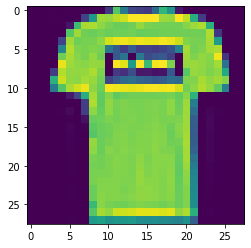

In [15]:
show_img(X_train[1])

In [19]:
input_shape = (28, 28, 1)
kernel_size = (3,3)
activation = 'relu'
padding = 'same'
pool_size = (2,2)

input_layer = tf.keras.layers.Input(input_shape)

x = Conv2D(16, kernel_size=kernel_size, activation=activation, padding=padding)(input_layer)
x = MaxPooling2D(pool_size)(x)

x = Conv2D(32,kernel_size=kernel_size, activation=activation, padding=padding)(x)
x = MaxPooling2D(pool_size)(x)

x = Conv2D(64, kernel_size=kernel_size, activation=activation, padding=padding)(x)
x = MaxPooling2D(pool_size)(x)

x = Conv2D(128,kernel_size=kernel_size, activation=activation, padding=padding)(x)

x = GlobalAveragePooling2D()(x)

x = Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0     

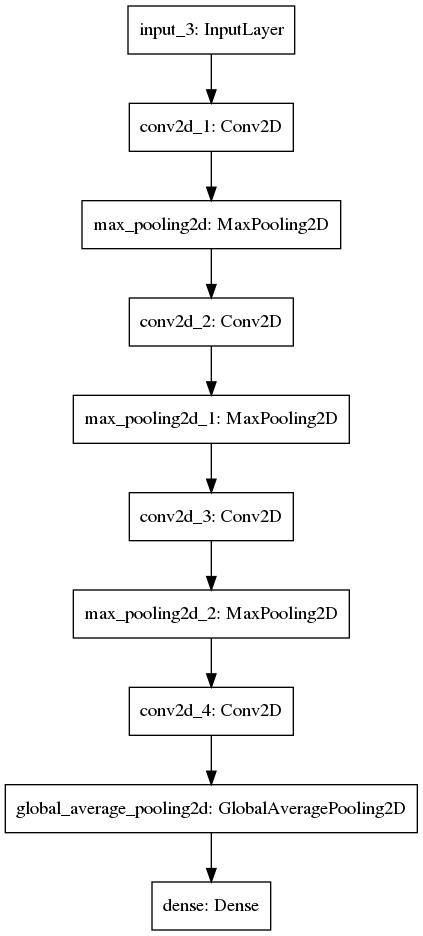

In [20]:
plot_model(model)

In [22]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3, verbose=0)

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=10, validation_split=0.1, shuffle=True, callbacks=[es])

Epoch 1/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3805 - accuracy: 0.8603 - val_loss: 0.3426 - val_accuracy: 0.8738
Epoch 2/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3138 - accuracy: 0.8854 - val_loss: 0.2805 - val_accuracy: 0.8975
Epoch 3/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2783 - accuracy: 0.8971 - val_loss: 0.2771 - val_accuracy: 0.8987
Epoch 4/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2511 - accuracy: 0.9076 - val_loss: 0.2644 - val_accuracy: 0.9040
Epoch 5/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2290 - accuracy: 0.9151 - val_loss: 0.2490 - val_accuracy: 0.9090
Epoch 6/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2126 - accuracy: 0.9203 - val_loss: 0.2435 - val_accuracy: 0.9093
Epoch 7/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1961 - accuracy: 0.9275 - val_loss: 0.2357 - val_accuracy:

In [26]:
# restorinng the result of the last cell since I forgot to do history = for before training
# and I don't wanna repeat training
history = _

In [27]:
history

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

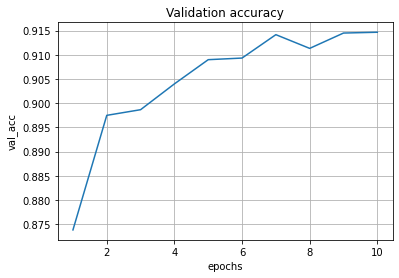

In [36]:
x_axis = np.arange(1, len(history.history['val_accuracy'])+1 )
y_axis = history.history['val_accuracy']
plt.plot(x_axis, y_axis)
plt.title('Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('val_acc')
plt.grid()

## Generate the class activation maps

To generate the class activation map, we want to get the features detected in the last convolution layer and see which ones are most active when generating the output probabilities. In our model above, we are interested in the layers shown below.

In [38]:
# final conv layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_4
global_average_pooling2d
dense


In [39]:
model.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_3')>

In [40]:
# now create the CAM (class activation map) model
# we do this so we can get the output of the last conv
# as well as the classifier output

last_conv_layer = model.layers[-3].output
dense_classifier_layer = model.layers[-1].output

cam_model = tf.keras.models.Model(inputs = model.input, outputs = (last_conv_layer, dense_classifier_layer))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0   

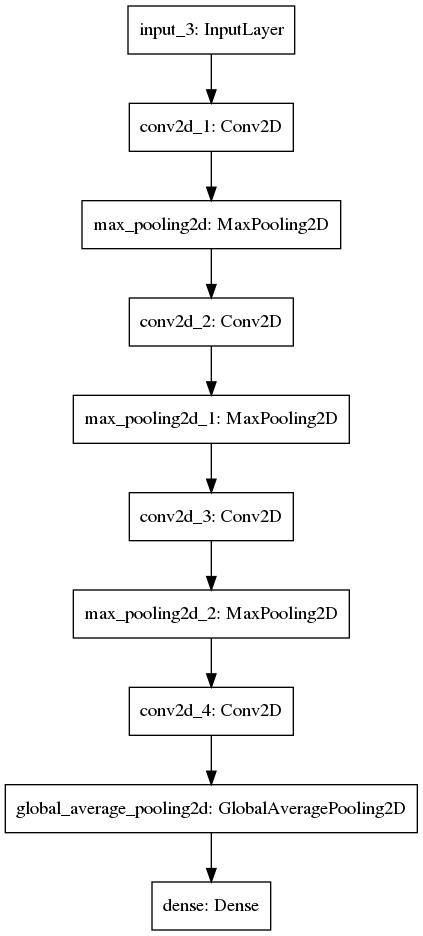

In [41]:
plot_model(cam_model)

In [43]:
last_conv_features, classifier_predictions = cam_model.predict(X_test)

# shape of the features
print("features shape: ", last_conv_features.shape)
print("results shape", classifier_predictions.shape)

features shape:  (10000, 3, 3, 128)
results shape (10000, 10)




You can generate the CAM by getting the dot product of the class activation features and the class activation weights.

You will need the weights from the Global Average Pooling layer (GAP) to calculate the activations of each feature given a particular class.

    Note that you'll get the weights from the dense layer that follows the global average pooling layer.
        The last conv2D layer has (h,w,depth) of (3 x 3 x 128), so there are 128 features.
        The global average pooling layer collapses the h,w,f (3 x 3 x 128) into a dense layer of 128 neurons (1 neuron per feature).
        The activations from the global average pooling layer get passed to the last dense layer.
        The last dense layer assigns weights to each of those 128 features (for each of the 10 classes),
        So the weights of the last dense layer (which immmediately follows the global average pooling layer) are referred to in this context as the "weights of the global average pooling layer".

For each of the 10 classes, there are 128 features, so there are 128 feature weights, one weight per feature.


In [49]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]


# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


In [50]:
# Get the features for the image at index 0
idx = 0
features_for_img = last_conv_features[idx,:,:,:]
print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


In [51]:
# The features have height and width of 3 by 3.
# Scale them up to the original image height and width, which is 28 by 28.

features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=5 )


# Check the shape after scaling up to 28 by 28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)


features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


For a particular class (0...9), get the 128 weights.

Take the dot product with the scaled features for this selected image with the weights.

The shapes are: scaled features: (h,w,depth) of (28 x 28 x 128). weights for one class: 128

The dot product produces the class activation map, with the shape equal to the height and width of the image: 28 x 28.

In [54]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)

# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


In [58]:
print('sample softmax output of the classifier', classifier_predictions[0])
print('sample prediction', np.argmax(classifier_predictions[0]))


sample softmax output of the classifier [2.7603352e-05 6.5229253e-11 8.3144151e-08 2.8448909e-08 2.3594974e-07
 1.6053785e-02 5.4293108e-09 6.2951846e-03 1.0033503e-06 9.7762203e-01]
sample prediction 9



## Conceptual interpretation

To think conceptually about what you're doing and why:

    * In the 28 x 28 x 128 feature map, each of the 128 feature filters is tailored to look for a specific set of features (for example, a shoelace).
        The actual features are learned, not selected by you directly.
    * Each of the 128 weights for a particular class decide how much weight to give to each of the 128 features, for that class.
        For instance, for the "shoe" class, it may have a higher weight for the feature filters that look for shoelaces.
    * At each of the 28 by 28 pixels, you can take the vector of 128 features and compare them with the vector of 128 weights.
        * You can do this comparison with a dot product.
        * The dot product results in a scalar value at each pixel.
        * Apply this dot product across all of the 28 x 28 pixels.
        * The scalar result of the dot product will be larger when the image both has the particular feature (e.g. shoelace), and that feature is also weighted more heavily for the particular class (e.g shoe).

So you've created a matrix with the same number of pixels as the image, where the value at each pixel is higher when that pixel is relevant to the prediction of a particular class.

Here is the function that implements the Class activation map calculations that you just saw.


In [59]:
def show_cam(image_index):
    '''displays the class activation map of a particular image'''

    # takes the features of the chosen image
    features_for_img = last_conv_features[image_index,:, :, :]

    # get the class with highest output probability
    prediction = np.argmax(classifier_predictions[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:,prediction]

    # upsample the features to the image's original size (28 x 28)
    class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=5)

    # compute the intensity of each feature in the CAM
    cam_output = np.dot(class_activation_features, class_activation_weights)

    #show the upsampled image use np.squeeze to remove the last channel dim
    plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)

    # strongly classified (95% probability) images will be in green, else red
    if classifier_predictions[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()



    

In [ ]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(classifier_predictions[i]) == desired_class:
            counter += 1
            show_cam(i)



For class 8 (handbag), you'll notice that most of the images have dark spots in the middle and right side.

   * This means that these areas were given less importance when categorizing the image.
   * The other parts such as the outline or handle contribute more when deciding if an image is a handbag or not.

Observe the other classes and see if there are also other common areas that the model uses more in determining the class of the image.


please choose a class less than 10


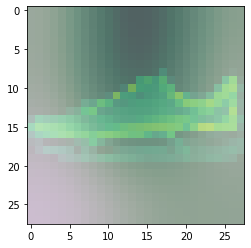

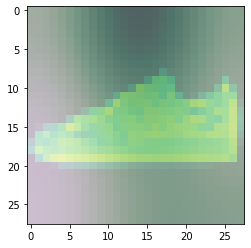

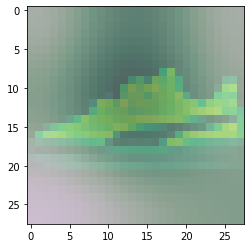

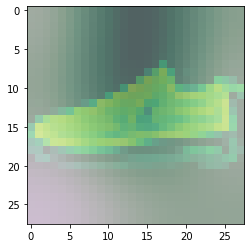

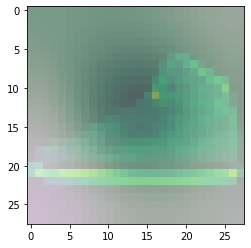

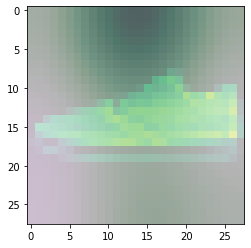

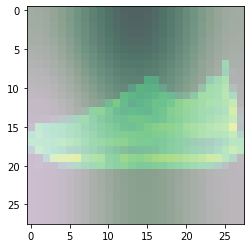

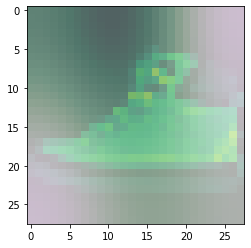

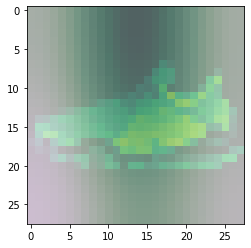

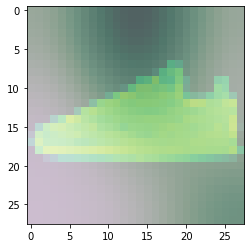

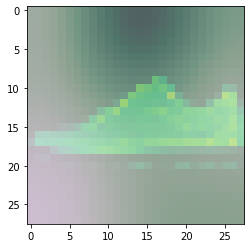

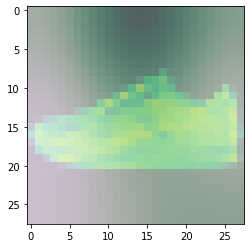

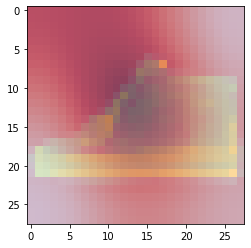

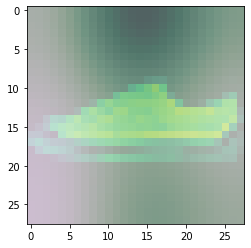

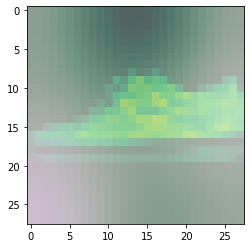

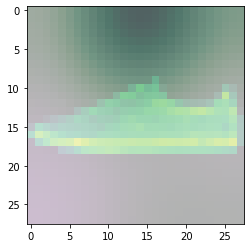

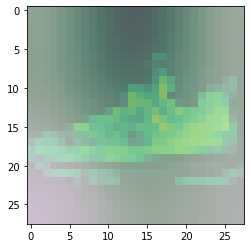

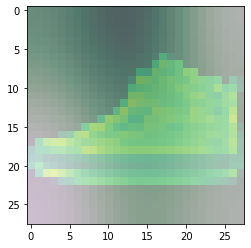

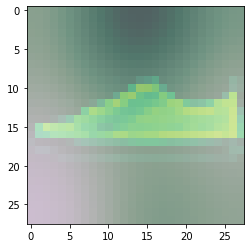

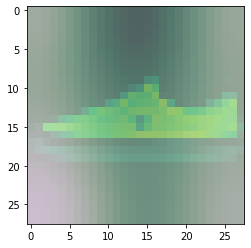

In [61]:
show_maps(desired_class=7, num_maps=20)

please choose a class less than 10


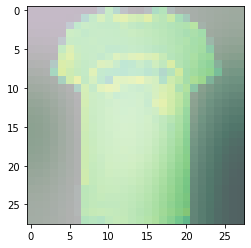

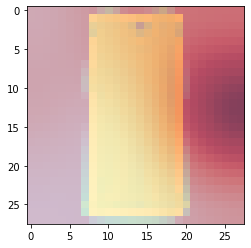

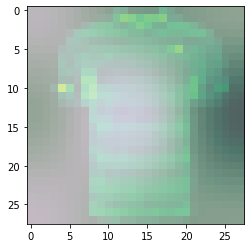

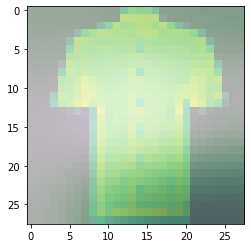

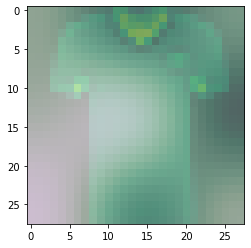

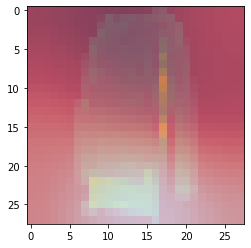

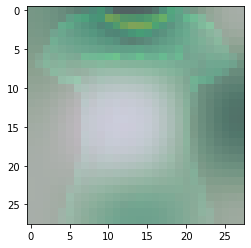

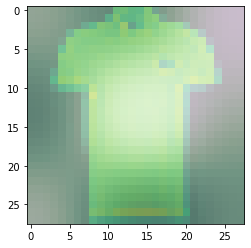

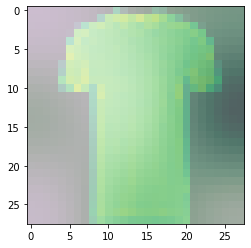

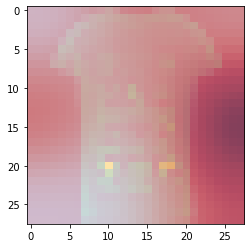

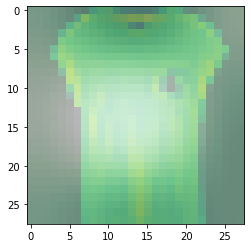

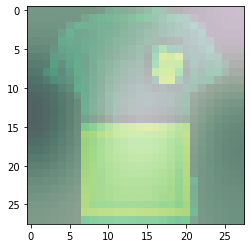

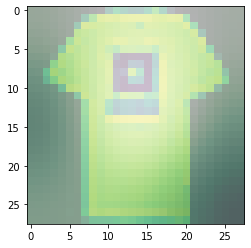

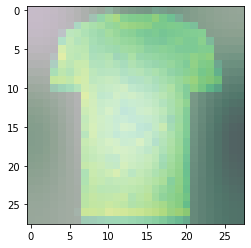

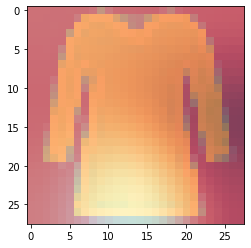

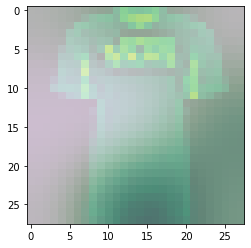

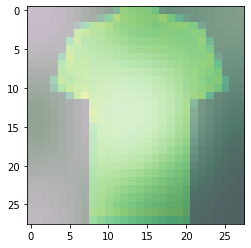

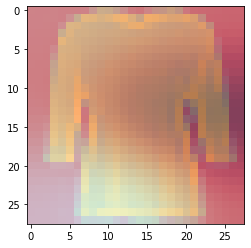

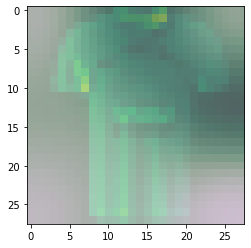

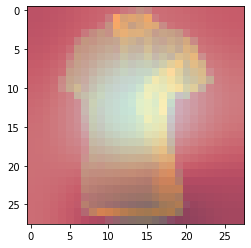

In [62]:
show_maps(desired_class=0, num_maps=20)